<a href="https://colab.research.google.com/github/ychencq/ECE247/blob/master/Project/Combination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras

TensorFlow 2.x selected.


In [ ]:
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Permute, Bidirectional, BatchNormalization, Conv1D, LSTM, Dense, Dropout, GRU, ReLU, ELU, Flatten, MaxPool1D, TimeDistributed
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import lecun_uniform
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np
X_test = np.load("drive/Shared drives/ECE C247 Final Project/project/X_test.npy")
y_test = np.load("drive/Shared drives/ECE C247 Final Project/project/y_test.npy")
person_train_valid = np.load("drive/Shared drives/ECE C247 Final Project/project/person_train_valid.npy")
X_train_valid = np.load("drive/Shared drives/ECE C247 Final Project/project/X_train_valid.npy")
y_train_valid = np.load("drive/Shared drives/ECE C247 Final Project/project/y_train_valid.npy")
person_test = np.load("drive/Shared drives/ECE C247 Final Project/project/person_test.npy")


### Shape of data

In [ ]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


### Preprocessing the Dataset

### denoised signal

In [ ]:
from scipy.signal import savgol_filter
X_train_valid_smooth = np.empty_like(X_train_valid)
X_test_smooth = np.empty_like(X_test)
for i in range(2115):
    for j in range(22):
        filtered = savgol_filter(X_train_valid[(i,j)],11,3)
        X_train_valid_smooth[(i,j)] = filtered
for i in range(443):
    for j in range(22):
        filtered = savgol_filter(X_test[(i,j)],11,3)
        X_test_smooth[(i,j)] = filtered
X_train_valid_smooth.shape

(2115, 22, 1000)

### Data Augmentation

In [ ]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=2.5, scale=sigma, size=X.shape)
    return np.multiply(X,scalingFactor)
# Down Sampling 
def DA_Downsampling(X):
    X_keepodd = np.empty_like(X)
    X_keepeven = np.empty_like(X)
    for i in range(1000):
        if(i==0):
            X_keepodd[i] = X[i]
            X_keepeven[i] = X[i]
        else:
            if i%2 == 0:
                X_keepodd[i] = X[i-1]
                X_keepeven[i] = X[i]
            else:
                X_keepeven[i] = X[i-1]
                X_keepodd[i] = X[i]
    return X_keepodd, X_keepeven

In [ ]:
# jitter
X_train_smooth_jitter = np.empty_like(X_train_valid_smooth)
X_test_smooth_jitter = np.empty_like(X_test_smooth)
for i in range(2115):
    for j in range(22):
        jittered = DA_Jitter(X_train_valid_smooth[(i,j)], 0.3)
        X_train_smooth_jitter[(i,j)] = jittered
for i in range(443):
    for j in range(22):
        jittered = DA_Jitter(X_test_smooth[(i,j)], 0.3)
        X_test_smooth_jitter[(i,j)] = jittered

#  scaled
X_train_smooth_scaled = np.empty_like(X_train_valid_smooth)
X_test_smooth_scaled = np.empty_like(X_test_smooth)
for i in range(2115):
    for j in range(22):
        scaled = DA_Scaling(X_train_valid_smooth[(i,j)], 0.1)
        X_train_smooth_scaled[(i,j)] = scaled
for i in range(443):
    for j in range(22):
        scaled = DA_Scaling(X_test_smooth[(i,j)], 0.1)
        X_test_smooth_scaled[(i,j)] = scaled

# down sampling, keep odd or even 
X_train_smooth_odd = np.empty_like(X_train_valid_smooth)
X_train_smooth_even = np.empty_like(X_train_valid_smooth)
X_test_smooth_odd = np.empty_like(X_test_smooth)
X_test_smooth_even = np.empty_like(X_test_smooth)
for i in range(2115):
    for j in range(22):
        odd, even = DA_Downsampling(X_train_valid_smooth[(i,j)])
        X_train_smooth_odd[(i,j)] = odd
        X_train_smooth_even[(i,j)] = even
for i in range(443):
    for j in range(22):
        odd, even = DA_Downsampling(X_test_smooth[(i,j)])
        X_test_smooth_odd[(i,j)] = odd
        X_test_smooth_even[(i,j)] = even

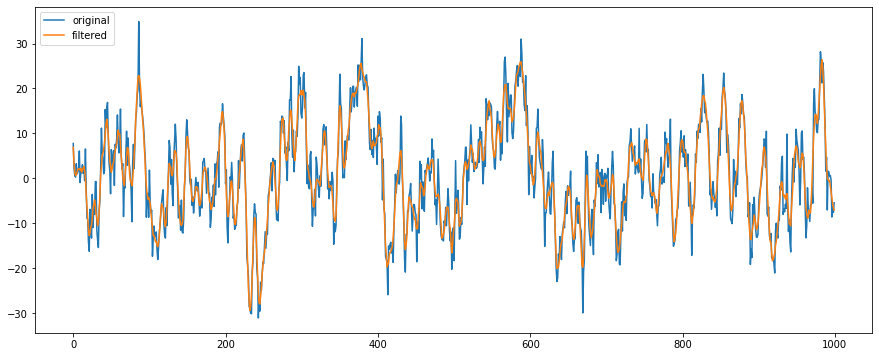

In [ ]:
fig = plt.figure(figsize=(15,6))
plt.plot(xaxis, filter_test, label="original")
plt.plot(xaxis, filtered, label="filtered")
plt.legend(loc="upper left")

plt.show()

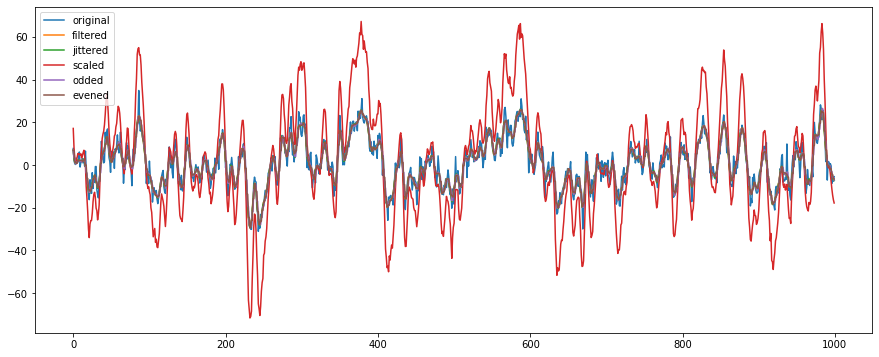

In [ ]:
filter_test = X_train_valid[(0,3)]
filtered = X_train_valid_smooth[(0,3)]
jitterf = X_train_smooth_jitter[(0,3)]
scaled2 = X_train_smooth_scaled[(0,3)]
odded = X_train_smooth_odd[(0,3)]
evened = X_train_smooth_even[(0,3)]
xaxis = range(1000)
fig = plt.figure(figsize=(15,6))
plt.plot(xaxis, filter_test, label="original")
plt.plot(xaxis, filtered, label="filtered")
plt.plot(xaxis, jitterf, label="jittered")
plt.plot(xaxis, scaled2, label="scaled")
plt.plot(xaxis, odded, label="odded")
plt.plot(xaxis, evened, label="evened")

plt.legend(loc="upper left")

plt.show()

In [ ]:
X_train_augment = np.concatenate((X_train_valid_smooth,X_train_smooth_jitter,X_train_smooth_odd,X_train_smooth_even), axis=0)
y_train_augment =  np.concatenate((y_train_valid,y_train_valid,y_train_valid,y_train_valid),axis=0)
print(X_train_augment.shape,y_train_augment.shape)

(8460, 22, 1000) (8460,)


In [ ]:
X_train_valid = X_train_valid.transpose(0,2,1)
X_train_valid_smooth = X_train_valid_smooth.transpose(0,2,1)
X_train_augment = X_train_augment.transpose(0,2,1)

X_test = X_test.transpose(0,2,1)
X_test_smooth = X_test_smooth.transpose(0,2,1)

y_train_valid = to_categorical(y_train_valid - 769)
y_train_augment = to_categorical(y_train_augment - 769)
y_test = to_categorical(y_test - 769)

In [ ]:
X_train_augment.shape

(8460, 1000, 22)

In [ ]:
y_train_augment.shape

(8460, 4)

# Trials of all models

## Naive CNN

In [ ]:
def naive_cnn(kernel_initializer, time_period):
    model = tf.keras.Sequential()

    model.add(Conv1D(16, kernel_size=20, strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01), input_shape=(time_period, 22), data_format='channels_last'))
    model.add(ELU())
    model.add(BatchNormalization(axis=2))  
    model.add(MaxPool1D(2))
    model.add(Dropout(0.4))

    model.add(Conv1D(32, kernel_size=15, strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=2))
    model.add(MaxPool1D(2))
    model.add(Dropout(0.4))

    model.add(Conv1D(64, kernel_size=10, strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=2))
    model.add(MaxPool1D(2))
    model.add(Dropout(0.4))


    model.add(Flatten())

    model.add(Dense(32, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='relu'))
    model.add(Dense(16, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='relu'))
    model.add(Dense(4, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])
    
    return model

## CRNN

In [ ]:
def CRNN(kernel_initializer, time_period):
    model = tf.keras.Sequential()

    model.add(Conv1D(16, kernel_size=20, strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01), input_shape=(time_period, 22), data_format='channels_last'))
    model.add(ELU())
    model.add(BatchNormalization(axis=2))

    model.add(Conv1D(32, kernel_size=20, strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=2))
    model.add(MaxPool1D(4))

    model.add(Conv1D(64, kernel_size=10, strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=2))
    model.add(MaxPool1D(4))

    # model.add(Conv1D(128, kernel_size=10, strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    # model.add(ELU())
    # model.add(BatchNormalization(axis=2))
    # model.add(MaxPool1D(4))
    model.add(Dropout(0.4))
    
    model.add(Bidirectional(LSTM(128, kernel_initializer=kernel_initializer, return_sequences=True)))
    model.add(Bidirectional(LSTM(64, kernel_initializer=kernel_initializer, return_sequences=True)))
    model.add(Bidirectional(LSTM(32, kernel_initializer=kernel_initializer)))
    model.add(Dropout(0.4))
    model.add(Dense(4, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, epsilon=1e-8, decay=0.01), metrics=[categorical_accuracy])
    
    return model

In [ ]:
def C4RNN(kernel_initializer, time_period):
    model = tf.keras.Sequential()

    model.add(Conv1D(16, kernel_size=20, strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01), input_shape=(time_period, 22), data_format='channels_last'))
    model.add(ELU())
    model.add(BatchNormalization(axis=2))

    model.add(Conv1D(32, kernel_size=20, strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=2))
    model.add(MaxPool1D(4))

    model.add(Conv1D(64, kernel_size=10, strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=2))
    model.add(MaxPool1D(4))

    model.add(Conv1D(128, kernel_size=10, strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=2))
    model.add(MaxPool1D(4))
    model.add(Dropout(0.4))
    
    model.add(Bidirectional(LSTM(128, kernel_initializer=kernel_initializer, return_sequences=True)))
    model.add(Bidirectional(LSTM(64, kernel_initializer=kernel_initializer, return_sequences=True)))
    model.add(Bidirectional(LSTM(32, kernel_initializer=kernel_initializer)))
    model.add(Dropout(0.4))
    model.add(Dense(4, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, epsilon=1e-8, decay=0.01), metrics=[categorical_accuracy])
    
    return model

In [ ]:
def CNN_GRU(kernel_initializer, time_period):
    model = tf.keras.Sequential()

    model.add(Conv1D(16, kernel_size=20, strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01), input_shape=(time_period, 22), data_format='channels_last'))
    model.add(ELU())
    model.add(BatchNormalization(axis=2))

    model.add(Conv1D(32, kernel_size=20, strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=2))
    model.add(MaxPool1D(4))

    model.add(Conv1D(64, kernel_size=10, strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=2))
    model.add(MaxPool1D(4))

    model.add(Conv1D(128, kernel_size=10, strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=2))
    model.add(MaxPool1D(4))
    model.add(Dropout(0.4))
    
    model.add(Bidirectional(GRU(128, kernel_initializer=kernel_initializer, return_sequences=True)))
    model.add(Bidirectional(GRU(64, kernel_initializer=kernel_initializer, return_sequences=True)))
    model.add(Bidirectional(GRU(32, kernel_initializer=kernel_initializer)))
    model.add(Dropout(0.4))
    model.add(Dense(4, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, epsilon=1e-8, decay=0.01), metrics=[categorical_accuracy])
    
    return model

## Naive LSTM

In [ ]:
def naive_LSTM(kernel_initializer, time_period):
    model = tf.keras.Sequential()

    model.add(Bidirectional(LSTM(128, kernel_initializer=kernel_initializer, return_sequences=True)))
    model.add(Bidirectional(LSTM(64, kernel_initializer=kernel_initializer, return_sequences=True)))
    model.add(Bidirectional(LSTM(32, kernel_initializer=kernel_initializer)))
    model.add(Dropout(0.4))
    model.add(Dense(4, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, epsilon=1e-8, decay=0.01), metrics=[categorical_accuracy])
    
    return model

In [ ]:
def train(model_type = None, sub_idx=None, time_period=None, X_train=None, X_test=None):
    # different period of time
    X_train_cur = X_train[:, :time_period, :]
    #change y_train_cur to y_train_augment when input is X_train_augment
    if X_train.shape[0] > 2115:
        y_train_cur = y_train_augment
    else:
        y_train_cur = y_train_valid
    X_test_cur = X_test[:, :time_period, :]
    y_test_cur = y_test

    # single subject dataset
    if sub_idx is not None:
        X_train_cur = X_train_cur[np.where(person_train_valid == sub_idx)[0]]
        y_train_cur = y_train_cur[np.where(person_train_valid == sub_idx)[0]]
        X_test_cur = X_test_cur[np.where(person_test == sub_idx)[0]]
        y_test_cur = y_test_cur[np.where(person_test == sub_idx)[0]]

    lecun = lecun_uniform(seed=42)
    
    model = model_type(lecun, time_period)

    history = model.fit(X_train_cur, y_train_cur, epochs=50, batch_size=32, validation_data=(X_test_cur, y_test_cur), shuffle=True, verbose=1)
    train_score = model.evaluate(X_train_cur, y_train_cur)
    test_score = model.evaluate(X_test_cur, y_test_cur)

    print('train {:s}: {:.3f}%'.format(model.metrics_names[1], train_score[1]*100))
    print('test {:s}: {:.3f}%'.format(model.metrics_names[1], test_score[1]*100))
    print(model.summary())
    # Plot training & validation accuracy values
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

Train on 6345 samples, validate on 443 samples
Epoch 1/50
6345/6345 [==============================] - 19s 3ms/sample - loss: 2.2958 - categorical_accuracy: 0.4197 - val_loss: 1.9524 - val_categorical_accuracy: 0.4357
Epoch 2/50
6345/6345 [==============================] - 7s 1ms/sample - loss: 1.5697 - categorical_accuracy: 0.6326 - val_loss: 1.6152 - val_categorical_accuracy: 0.5621
Epoch 3/50
6345/6345 [==============================] - 7s 1ms/sample - loss: 1.2975 - categorical_accuracy: 0.7266 - val_loss: 1.4785 - val_categorical_accuracy: 0.6208
Epoch 4/50
6345/6345 [==============================] - 7s 1ms/sample - loss: 1.1140 - categorical_accuracy: 0.7913 - val_loss: 1.5568 - val_categorical_accuracy: 0.5982
Epoch 5/50
6345/6345 [==============================] - 7s 1ms/sample - loss: 0.9904 - categorical_accuracy: 0.8331 - val_loss: 1.6328 - val_categorical_accuracy: 0.5914
Epoch 6/50
6345/6345 [==============================] - 7s 1ms/sample - loss: 0.8728 - categorical_acc

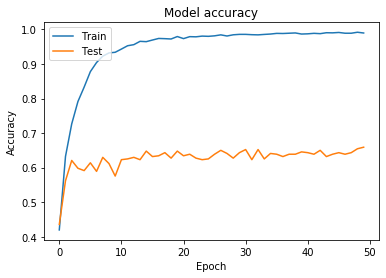

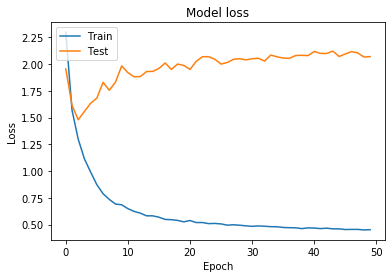

In [ ]:
train(C4RNN,time_period=1000,X_train=X_train_augment,X_test=X_test_smooth)

Train on 6345 samples, validate on 443 samples
Epoch 1/50
6345/6345 [==============================] - 20s 3ms/sample - loss: 2.7255 - categorical_accuracy: 0.3620 - val_loss: 2.4227 - val_categorical_accuracy: 0.3747
Epoch 2/50
6345/6345 [==============================] - 10s 2ms/sample - loss: 2.1061 - categorical_accuracy: 0.5245 - val_loss: 2.0494 - val_categorical_accuracy: 0.4898
Epoch 3/50
6345/6345 [==============================] - 10s 2ms/sample - loss: 1.7505 - categorical_accuracy: 0.6351 - val_loss: 1.8598 - val_categorical_accuracy: 0.5734
Epoch 4/50
6345/6345 [==============================] - 10s 2ms/sample - loss: 1.5075 - categorical_accuracy: 0.7209 - val_loss: 1.8978 - val_categorical_accuracy: 0.5440
Epoch 5/50
6345/6345 [==============================] - 10s 2ms/sample - loss: 1.3315 - categorical_accuracy: 0.7816 - val_loss: 1.7532 - val_categorical_accuracy: 0.5982
Epoch 6/50
6345/6345 [==============================] - 10s 2ms/sample - loss: 1.2069 - categorica

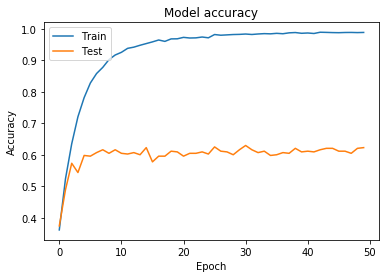

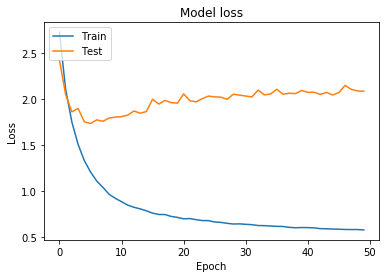

In [ ]:
train(CNN_GRU,time_period=1000,X_train=X_train_augment,X_test=X_test_smooth)

Train on 6345 samples, validate on 443 samples
Epoch 1/50
6345/6345 [==============================] - 20s 3ms/sample - loss: 2.2829 - categorical_accuracy: 0.4046 - val_loss: 1.8893 - val_categorical_accuracy: 0.4424
Epoch 2/50
6345/6345 [==============================] - 11s 2ms/sample - loss: 1.6032 - categorical_accuracy: 0.5746 - val_loss: 1.7133 - val_categorical_accuracy: 0.4628
Epoch 3/50
6345/6345 [==============================] - 11s 2ms/sample - loss: 1.3156 - categorical_accuracy: 0.6853 - val_loss: 1.5666 - val_categorical_accuracy: 0.5418
Epoch 4/50
6345/6345 [==============================] - 11s 2ms/sample - loss: 1.1376 - categorical_accuracy: 0.7573 - val_loss: 1.4302 - val_categorical_accuracy: 0.6140
Epoch 5/50
6345/6345 [==============================] - 11s 2ms/sample - loss: 1.0047 - categorical_accuracy: 0.8061 - val_loss: 1.5215 - val_categorical_accuracy: 0.6253
Epoch 6/50
6345/6345 [==============================] - 11s 2ms/sample - loss: 0.9077 - categorica

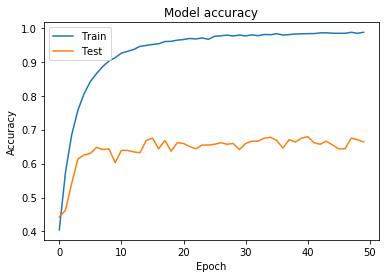

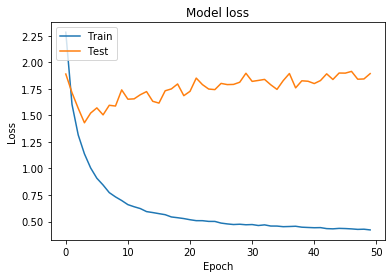

In [ ]:
train(C4RNN,time_period=1000,X_train=X_train_augment,X_test=X_test_smooth)

Train on 8460 samples, validate on 443 samples
Epoch 1/50
8460/8460 [==============================] - 73s 9ms/sample - loss: 1.3870 - categorical_accuracy: 0.3719 - val_loss: 1.5141 - val_categorical_accuracy: 0.2596
Epoch 2/50
8460/8460 [==============================] - 61s 7ms/sample - loss: 1.0764 - categorical_accuracy: 0.6199 - val_loss: 1.7017 - val_categorical_accuracy: 0.2438
Epoch 3/50
8460/8460 [==============================] - 61s 7ms/sample - loss: 0.7176 - categorical_accuracy: 0.8002 - val_loss: 1.9484 - val_categorical_accuracy: 0.2348
Epoch 4/50
8460/8460 [==============================] - 61s 7ms/sample - loss: 0.4610 - categorical_accuracy: 0.9033 - val_loss: 2.1985 - val_categorical_accuracy: 0.2280
Epoch 5/50
8460/8460 [==============================] - 61s 7ms/sample - loss: 0.3430 - categorical_accuracy: 0.9427 - val_loss: 2.3259 - val_categorical_accuracy: 0.2348
Epoch 6/50
8460/8460 [==============================] - 61s 7ms/sample - loss: 0.2639 - categorica

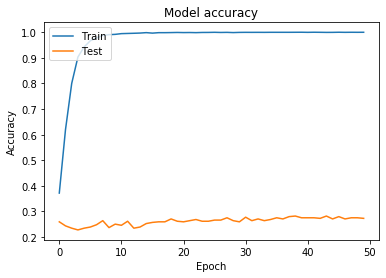

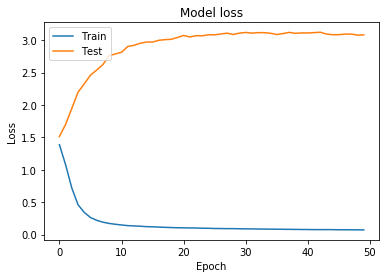

In [ ]:
train(naive_LSTM,time_period=1000,X_train=X_train_augment,X_test=X_test_smooth)

Train on 2115 samples, validate on 443 samples
Epoch 1/50
2115/2115 [==============================] - 8s 4ms/sample - loss: 3.0399 - categorical_accuracy: 0.2875 - val_loss: 2.8416 - val_categorical_accuracy: 0.2822
Epoch 2/50
2115/2115 [==============================] - 1s 601us/sample - loss: 2.6586 - categorical_accuracy: 0.3853 - val_loss: 2.5170 - val_categorical_accuracy: 0.3612
Epoch 3/50
2115/2115 [==============================] - 1s 609us/sample - loss: 2.3945 - categorical_accuracy: 0.4251 - val_loss: 2.3531 - val_categorical_accuracy: 0.4086
Epoch 4/50
2115/2115 [==============================] - 1s 591us/sample - loss: 2.2269 - categorical_accuracy: 0.4657 - val_loss: 2.2153 - val_categorical_accuracy: 0.4221
Epoch 5/50
2115/2115 [==============================] - 1s 596us/sample - loss: 2.0670 - categorical_accuracy: 0.5206 - val_loss: 2.0769 - val_categorical_accuracy: 0.4763
Epoch 6/50
2115/2115 [==============================] - 1s 612us/sample - loss: 1.9498 - catego

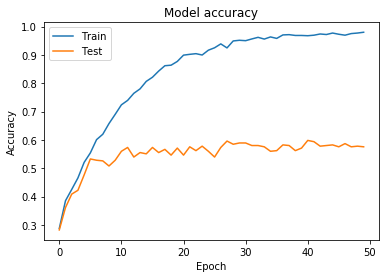

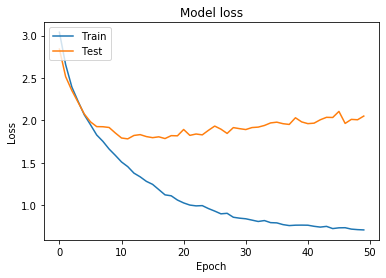

In [ ]:
train(CNN_GRU,time_period=1000,X_train=X_train_valid,X_test=X_test)

Train on 2115 samples, validate on 443 samples
Epoch 1/50
2115/2115 [==============================] - 15s 7ms/sample - loss: 3.0103 - categorical_accuracy: 0.3135 - val_loss: 2.7381 - val_categorical_accuracy: 0.3995
Epoch 2/50
2115/2115 [==============================] - 1s 646us/sample - loss: 2.6098 - categorical_accuracy: 0.4147 - val_loss: 2.4628 - val_categorical_accuracy: 0.4244
Epoch 3/50
2115/2115 [==============================] - 1s 624us/sample - loss: 2.3389 - categorical_accuracy: 0.4809 - val_loss: 2.2721 - val_categorical_accuracy: 0.4966
Epoch 4/50
2115/2115 [==============================] - 1s 647us/sample - loss: 2.1692 - categorical_accuracy: 0.5248 - val_loss: 2.1027 - val_categorical_accuracy: 0.5056
Epoch 5/50
2115/2115 [==============================] - 1s 624us/sample - loss: 1.9953 - categorical_accuracy: 0.5721 - val_loss: 2.0543 - val_categorical_accuracy: 0.5169
Epoch 6/50
2115/2115 [==============================] - 1s 642us/sample - loss: 1.8977 - categ

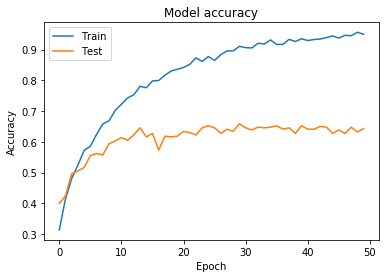

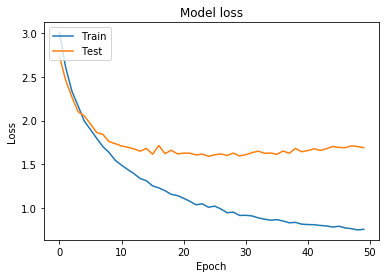

In [ ]:
train(CNN_GRU,time_period=1000,X_train=X_train_valid_smooth,X_test=X_test_smooth)

Train on 2115 samples, validate on 443 samples
Epoch 1/50
2115/2115 [==============================] - 2s 936us/sample - loss: 3.9680 - categorical_accuracy: 0.3154 - val_loss: 3.6268 - val_categorical_accuracy: 0.3251
Epoch 2/50
2115/2115 [==============================] - 1s 353us/sample - loss: 3.2917 - categorical_accuracy: 0.4208 - val_loss: 3.0233 - val_categorical_accuracy: 0.4176
Epoch 3/50
2115/2115 [==============================] - 1s 360us/sample - loss: 2.9909 - categorical_accuracy: 0.4931 - val_loss: 2.9199 - val_categorical_accuracy: 0.4334
Epoch 4/50
2115/2115 [==============================] - 1s 347us/sample - loss: 2.7386 - categorical_accuracy: 0.5504 - val_loss: 2.8633 - val_categorical_accuracy: 0.4199
Epoch 5/50
2115/2115 [==============================] - 1s 355us/sample - loss: 2.5156 - categorical_accuracy: 0.6284 - val_loss: 2.8741 - val_categorical_accuracy: 0.4402
Epoch 6/50
2115/2115 [==============================] - 1s 354us/sample - loss: 2.4075 - cate

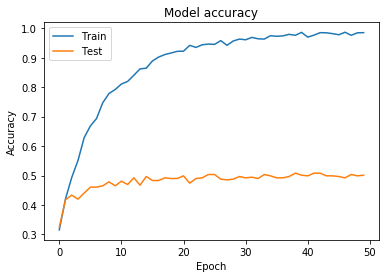

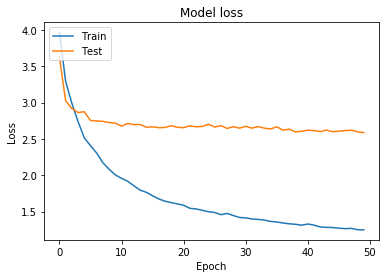

In [ ]:
train(naive_cnn,time_period=1000,X_train=X_train_valid,X_test=X_test)

Train on 8460 samples, validate on 443 samples
Epoch 1/50
8460/8460 [==============================] - 4s 477us/sample - loss: 2.5557 - categorical_accuracy: 0.4079 - val_loss: 2.1961 - val_categorical_accuracy: 0.3837
Epoch 2/50
8460/8460 [==============================] - 2s 242us/sample - loss: 1.7326 - categorical_accuracy: 0.5783 - val_loss: 1.7956 - val_categorical_accuracy: 0.4921
Epoch 3/50
8460/8460 [==============================] - 2s 239us/sample - loss: 1.4191 - categorical_accuracy: 0.6916 - val_loss: 1.7766 - val_categorical_accuracy: 0.5350
Epoch 4/50
8460/8460 [==============================] - 2s 242us/sample - loss: 1.2584 - categorical_accuracy: 0.7632 - val_loss: 1.7887 - val_categorical_accuracy: 0.5688
Epoch 5/50
8460/8460 [==============================] - 2s 243us/sample - loss: 1.2033 - categorical_accuracy: 0.7901 - val_loss: 1.9558 - val_categorical_accuracy: 0.5508
Epoch 6/50
8460/8460 [==============================] - 2s 241us/sample - loss: 1.1607 - cate

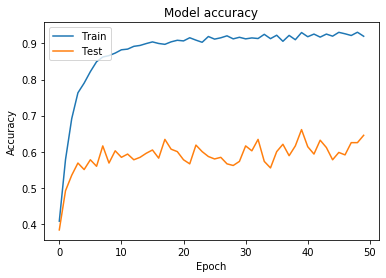

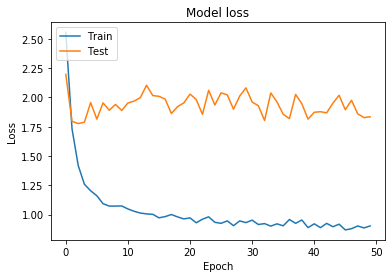

In [ ]:
train(naive_cnn,time_period=1000,X_train=X_train_augment,X_test=X_test_smooth)

Train on 2115 samples, validate on 443 samples
Epoch 1/50
2115/2115 [==============================] - 2s 868us/sample - loss: 3.1036 - categorical_accuracy: 0.2823 - val_loss: 2.8698 - val_categorical_accuracy: 0.3228
Epoch 2/50
2115/2115 [==============================] - 1s 279us/sample - loss: 2.6564 - categorical_accuracy: 0.3470 - val_loss: 2.5018 - val_categorical_accuracy: 0.3679
Epoch 3/50
2115/2115 [==============================] - 1s 273us/sample - loss: 2.3100 - categorical_accuracy: 0.3976 - val_loss: 2.1904 - val_categorical_accuracy: 0.4018
Epoch 4/50
2115/2115 [==============================] - 1s 268us/sample - loss: 2.0508 - categorical_accuracy: 0.4317 - val_loss: 2.0719 - val_categorical_accuracy: 0.3725
Epoch 5/50
2115/2115 [==============================] - 1s 271us/sample - loss: 1.8747 - categorical_accuracy: 0.4657 - val_loss: 1.9270 - val_categorical_accuracy: 0.4244
Epoch 6/50
2115/2115 [==============================] - 1s 273us/sample - loss: 1.7531 - cate

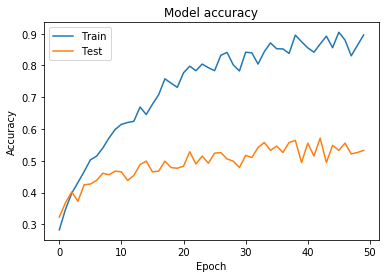

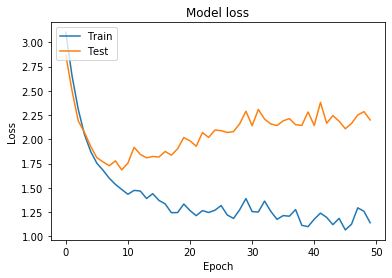

In [ ]:
train(naive_cnn,time_period=1000,X_train=X_train_valid_smooth,X_test=X_test_smooth)

Train on 2115 samples, validate on 443 samples
Epoch 1/40
2115/2115 [==============================] - 9s 4ms/sample - loss: 2.1351 - categorical_accuracy: 0.2851 - val_loss: 2.0144 - val_categorical_accuracy: 0.2506
Epoch 2/40
2115/2115 [==============================] - 2s 1ms/sample - loss: 1.8484 - categorical_accuracy: 0.3693 - val_loss: 1.8342 - val_categorical_accuracy: 0.3205
Epoch 3/40
2115/2115 [==============================] - 2s 1ms/sample - loss: 1.6916 - categorical_accuracy: 0.4203 - val_loss: 1.6564 - val_categorical_accuracy: 0.4312
Epoch 4/40
2115/2115 [==============================] - 2s 1ms/sample - loss: 1.5810 - categorical_accuracy: 0.4723 - val_loss: 1.5480 - val_categorical_accuracy: 0.4740
Epoch 5/40
2115/2115 [==============================] - 2s 1ms/sample - loss: 1.4871 - categorical_accuracy: 0.5414 - val_loss: 1.5171 - val_categorical_accuracy: 0.4831
Epoch 6/40
2115/2115 [==============================] - 2s 1ms/sample - loss: 1.4355 - categorical_accu

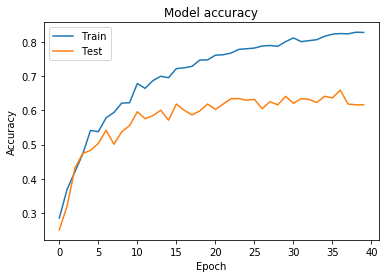

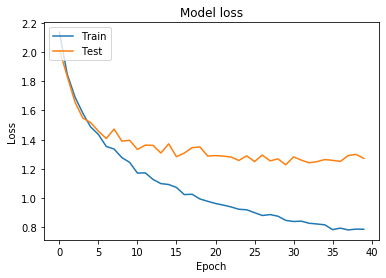

In [ ]:
train(CRNN,time_period=1000,X_train=X_train_valid,X_test=X_test)

Train on 2115 samples, validate on 443 samples
Epoch 1/40
2115/2115 [==============================] - 10s 4ms/sample - loss: 2.1793 - categorical_accuracy: 0.2861 - val_loss: 2.0654 - val_categorical_accuracy: 0.2596
Epoch 2/40
2115/2115 [==============================] - 2s 1ms/sample - loss: 1.8925 - categorical_accuracy: 0.3835 - val_loss: 1.7705 - val_categorical_accuracy: 0.4153
Epoch 3/40
2115/2115 [==============================] - 2s 1ms/sample - loss: 1.7416 - categorical_accuracy: 0.4326 - val_loss: 1.7329 - val_categorical_accuracy: 0.4244
Epoch 4/40
2115/2115 [==============================] - 2s 1ms/sample - loss: 1.6259 - categorical_accuracy: 0.4794 - val_loss: 1.6294 - val_categorical_accuracy: 0.4537
Epoch 5/40
2115/2115 [==============================] - 2s 1ms/sample - loss: 1.5473 - categorical_accuracy: 0.5130 - val_loss: 1.5591 - val_categorical_accuracy: 0.4898
Epoch 6/40
2115/2115 [==============================] - 2s 1ms/sample - loss: 1.4824 - categorical_acc

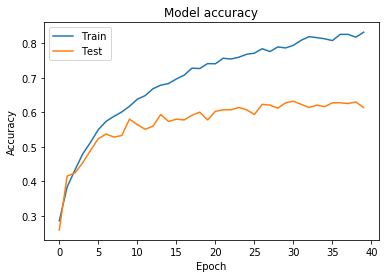

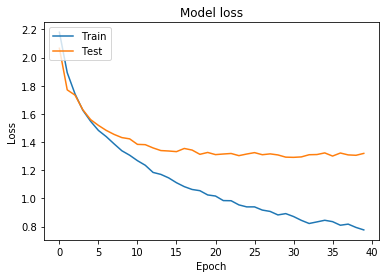

In [ ]:
train(CRNN,time_period=1000,X_train=X_train_valid_smooth,X_test=X_test_smooth)

Train on 2115 samples, validate on 443 samples
Epoch 1/40
2115/2115 [==============================] - 28s 13ms/sample - loss: 1.4885 - categorical_accuracy: 0.2615 - val_loss: 1.4736 - val_categorical_accuracy: 0.2122
Epoch 2/40
2115/2115 [==============================] - 22s 11ms/sample - loss: 1.4219 - categorical_accuracy: 0.3229 - val_loss: 1.4787 - val_categorical_accuracy: 0.2280
Epoch 3/40
2115/2115 [==============================] - 22s 10ms/sample - loss: 1.3808 - categorical_accuracy: 0.3887 - val_loss: 1.4991 - val_categorical_accuracy: 0.2122
Epoch 4/40
2115/2115 [==============================] - 22s 11ms/sample - loss: 1.3096 - categorical_accuracy: 0.4582 - val_loss: 1.5069 - val_categorical_accuracy: 0.2438
Epoch 5/40
2115/2115 [==============================] - 22s 11ms/sample - loss: 1.2543 - categorical_accuracy: 0.5102 - val_loss: 1.5266 - val_categorical_accuracy: 0.2257
Epoch 6/40
2115/2115 [==============================] - 22s 11ms/sample - loss: 1.1574 - cate

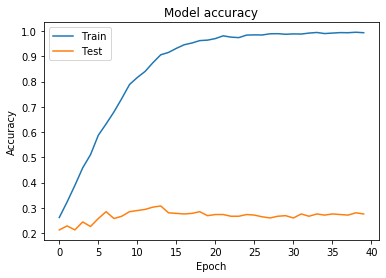

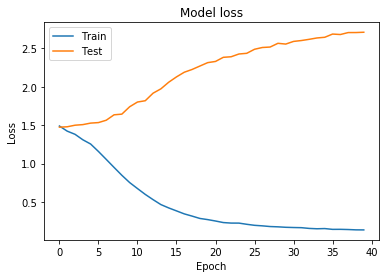

In [ ]:
train(naive_LSTM,time_period=1000,X_train=X_train_valid,X_test=X_test)

Train on 2115 samples, validate on 443 samples
Epoch 1/40
2115/2115 [==============================] - 29s 14ms/sample - loss: 1.4814 - categorical_accuracy: 0.2558 - val_loss: 1.4591 - val_categorical_accuracy: 0.2415
Epoch 2/40
2115/2115 [==============================] - 22s 11ms/sample - loss: 1.4161 - categorical_accuracy: 0.3253 - val_loss: 1.4670 - val_categorical_accuracy: 0.2460
Epoch 3/40
2115/2115 [==============================] - 22s 10ms/sample - loss: 1.3718 - categorical_accuracy: 0.3820 - val_loss: 1.4941 - val_categorical_accuracy: 0.2190
Epoch 4/40
2115/2115 [==============================] - 22s 11ms/sample - loss: 1.3243 - categorical_accuracy: 0.4496 - val_loss: 1.4969 - val_categorical_accuracy: 0.2370
Epoch 5/40
2115/2115 [==============================] - 22s 11ms/sample - loss: 1.2491 - categorical_accuracy: 0.5045 - val_loss: 1.5296 - val_categorical_accuracy: 0.2280
Epoch 6/40
2115/2115 [==============================] - 22s 10ms/sample - loss: 1.1605 - cate

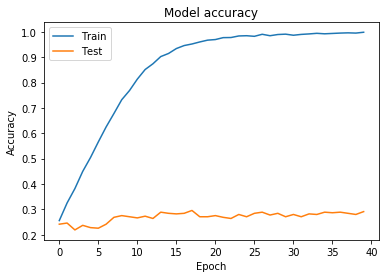

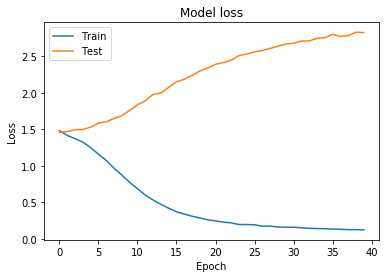

In [ ]:
train(naive_LSTM,time_period=1000,X_train=X_train_valid_smooth,X_test=X_test_smooth)

Train on 2115 samples, validate on 443 samples
Epoch 1/40
2115/2115 [==============================] - 9s 4ms/sample - loss: 2.7208 - categorical_accuracy: 0.2643 - val_loss: 2.3439 - val_categorical_accuracy: 0.2957
Epoch 2/40
2115/2115 [==============================] - 2s 804us/sample - loss: 2.0945 - categorical_accuracy: 0.3485 - val_loss: 1.9199 - val_categorical_accuracy: 0.3679
Epoch 3/40
2115/2115 [==============================] - 2s 745us/sample - loss: 1.8147 - categorical_accuracy: 0.4014 - val_loss: 1.7780 - val_categorical_accuracy: 0.3657
Epoch 4/40
2115/2115 [==============================] - 2s 795us/sample - loss: 1.6540 - categorical_accuracy: 0.4496 - val_loss: 1.6572 - val_categorical_accuracy: 0.4176
Epoch 5/40
2115/2115 [==============================] - 2s 797us/sample - loss: 1.5534 - categorical_accuracy: 0.4780 - val_loss: 1.5661 - val_categorical_accuracy: 0.4628
Epoch 6/40
2115/2115 [==============================] - 2s 762us/sample - loss: 1.4673 - catego

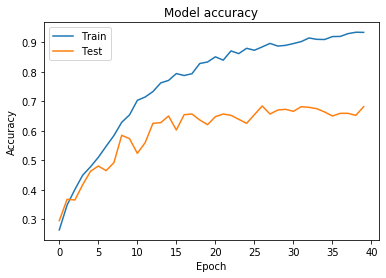

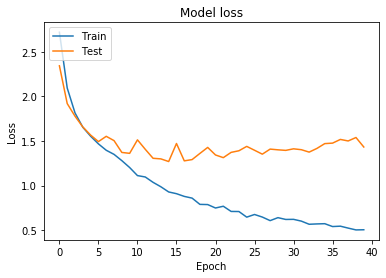

In [ ]:
train(C4RNN,time_period=1000,X_train=X_train_valid_smooth,X_test=X_test_smooth)

Train on 2115 samples, validate on 443 samples
Epoch 1/40
2115/2115 [==============================] - 9s 4ms/sample - loss: 2.7859 - categorical_accuracy: 0.2913 - val_loss: 2.4368 - val_categorical_accuracy: 0.2709
Epoch 2/40
2115/2115 [==============================] - 2s 809us/sample - loss: 2.1848 - categorical_accuracy: 0.3830 - val_loss: 2.0169 - val_categorical_accuracy: 0.4379
Epoch 3/40
2115/2115 [==============================] - 2s 769us/sample - loss: 1.8861 - categorical_accuracy: 0.4643 - val_loss: 1.7968 - val_categorical_accuracy: 0.4808
Epoch 4/40
2115/2115 [==============================] - 2s 798us/sample - loss: 1.6933 - categorical_accuracy: 0.5348 - val_loss: 1.6871 - val_categorical_accuracy: 0.4898
Epoch 5/40
2115/2115 [==============================] - 2s 777us/sample - loss: 1.5650 - categorical_accuracy: 0.5754 - val_loss: 1.6077 - val_categorical_accuracy: 0.5350
Epoch 6/40
2115/2115 [==============================] - 2s 805us/sample - loss: 1.4779 - catego

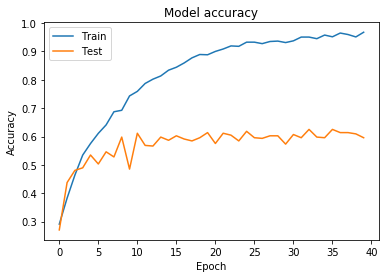

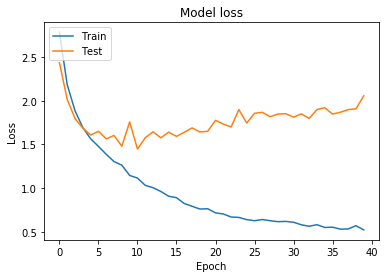

In [ ]:
train(C4RNN,time_period=1000,X_train=X_train_valid,X_test=X_test)

# Performance of different time period

In [ ]:
def trainVersusTime(model_type = None, sub_idx=None, X_train=None, X_test=None):
    # different period of time
    train_scores = []
    test_scores = []
    for time in range(300, 1001, 100):
        print("------------------------------------")
        print("Time Period: %d" %(time))
        X_train_cur = X_train[:, :time, :]
        y_train_cur = y_train_valid
        X_test_cur = X_test[:, :time, :]
        y_test_cur = y_test
        
        # single subject dataset
        if sub_idx is not None:
            X_train_cur = X_train_cur[np.where(person_train_valid == sub_idx)[0]]
            y_train_cur = y_train_cur[np.where(person_train_valid == sub_idx)[0]]
            X_test_cur = X_test_cur[np.where(person_test == sub_idx)[0]]
            y_test_cur = y_test_cur[np.where(person_test == sub_idx)[0]]

        lecun = lecun_uniform(seed=42)
        
        model = model_type(lecun, time_period = time)

        history = model.fit(X_train_cur, y_train_cur, epochs=40, batch_size=32, validation_data=(X_test_cur, y_test_cur), shuffle=True, verbose=1)
        train_score = model.evaluate(X_train_cur, y_train_cur)
        test_score = model.evaluate(X_test_cur, y_test_cur)
        train_scores.append(train_score[1]*100)
        test_scores.append(test_score[1]*100)
    
    plt.plot(range(300, 1001, 100), train_scores, label='train')
    plt.plot(range(300, 1001, 100), test_scores, label='test')
    plt.legend()
    plt.title("Accuracies of " + str(model_type)+ " Versus Time Period")
    plt.show()

    # print('train {:s}: {:.3f}%'.format(model.metrics_names[1], train_score[1]*100))
    # print('test {:s}: {:.3f}%'.format(model.metrics_names[1], test_score[1]*100))
    # print(model.summary())
    # # Plot training & validation accuracy values
    # plt.plot(history.history['categorical_accuracy'])
    # plt.plot(history.history['val_categorical_accuracy'])
    # plt.title('Model accuracy')
    # plt.ylabel('Accuracy')
    # plt.xlabel('Epoch')
    # plt.legend(['Train', 'Test'], loc='upper left')
    # plt.show()

    # # Plot training & validation loss values
    # plt.plot(history.history['loss'])
    # plt.plot(history.history['val_loss'])
    # plt.title('Model loss')
    # plt.ylabel('Loss')
    # plt.xlabel('Epoch')
    # plt.legend(['Train', 'Test'], loc='upper left')
    # plt.show()

------------------------------------
Time Period: 300
Train on 2115 samples, validate on 443 samples
Epoch 1/40
2115/2115 [==============================] - 8s 4ms/sample - loss: 2.1783 - categorical_accuracy: 0.3149 - val_loss: 1.7366 - val_categorical_accuracy: 0.3002
Epoch 2/40
2115/2115 [==============================] - 1s 541us/sample - loss: 1.6108 - categorical_accuracy: 0.3816 - val_loss: 1.5551 - val_categorical_accuracy: 0.3521
Epoch 3/40
2115/2115 [==============================] - 1s 561us/sample - loss: 1.4707 - categorical_accuracy: 0.4350 - val_loss: 1.4345 - val_categorical_accuracy: 0.4131
Epoch 4/40
2115/2115 [==============================] - 1s 547us/sample - loss: 1.3785 - categorical_accuracy: 0.4790 - val_loss: 1.3926 - val_categorical_accuracy: 0.4560
Epoch 5/40
2115/2115 [==============================] - 1s 538us/sample - loss: 1.3067 - categorical_accuracy: 0.5215 - val_loss: 1.3359 - val_categorical_accuracy: 0.4831
Epoch 6/40
2115/2115 [===================

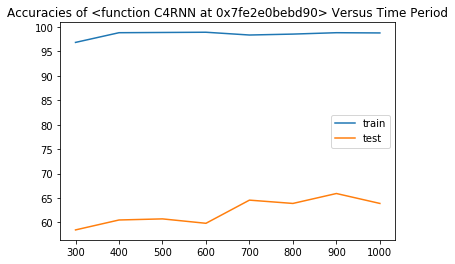

In [ ]:
trainVersusTime(C4RNN,sub_idx=None,X_train=X_train_valid_smooth,X_test=X_test_smooth)

# Performance over subject (use C4RNN here)

In [ ]:
def trainVersusSubject(model_type = None, X_train=None, X_test=None):
    # different period of time
    train_scores = []
    test_scores = []
    time_period = 1000
    for sub_idx in range(9):
        print("------------------------------------")
        print("Subject: %d" %(sub_idx))
        X_train_cur = X_train[:, :time_period, :]
        y_train_cur = y_train_valid
        X_test_cur = X_test[:, :time_period, :]
        y_test_cur = y_test
        
        # single subject dataset
        X_train_cur = X_train_cur[np.where(person_train_valid == sub_idx)[0]]
        y_train_cur = y_train_cur[np.where(person_train_valid == sub_idx)[0]]
        X_test_cur = X_test_cur[np.where(person_test == sub_idx)[0]]
        y_test_cur = y_test_cur[np.where(person_test == sub_idx)[0]]

        lecun = lecun_uniform(seed=42)
        
        model = model_type(lecun, time_period = 1000)

        history = model.fit(X_train_cur, y_train_cur, epochs=38, batch_size=32, validation_data=(X_test_cur, y_test_cur), shuffle=True, verbose=1)
        train_score = model.evaluate(X_train_cur, y_train_cur)
        test_score = model.evaluate(X_test_cur, y_test_cur)
        train_scores.append(train_score[1]*100)
        test_scores.append(test_score[1]*100)
    
    plt.figure()
    plt.bar(range(1,10), train_scores, color = 'deepskyblue', label='train')
    plt.xlabel('Subject')
    plt.legend()
    plt.title("Train Accuracies of " + str(model_type)+ " Versus Subject")
    plt.show()

    plt.figure()
    plt.bar(range(1,10), test_scores, color = 'darkorange' ,label='test')
    plt.xlabel('Subject')
    plt.legend()
    plt.title("Test Accuracies of " + str(model_type)+ " Versus Subject")
    plt.show()

    print('Train Accuracy:')
    print(train_scores)
    print('Test Accuracy')
    print(test_scores)


------------------------------------
Subject: 0
Train on 237 samples, validate on 50 samples
Epoch 1/38
237/237 [==============================] - 7s 30ms/sample - loss: 3.0813 - categorical_accuracy: 0.3165 - val_loss: 3.2526 - val_categorical_accuracy: 0.2800
Epoch 2/38
237/237 [==============================] - 0s 830us/sample - loss: 2.7428 - categorical_accuracy: 0.4979 - val_loss: 3.4487 - val_categorical_accuracy: 0.2400
Epoch 3/38
237/237 [==============================] - 0s 782us/sample - loss: 2.5060 - categorical_accuracy: 0.4726 - val_loss: 3.6790 - val_categorical_accuracy: 0.2400
Epoch 4/38
237/237 [==============================] - 0s 762us/sample - loss: 2.3382 - categorical_accuracy: 0.6034 - val_loss: 3.8056 - val_categorical_accuracy: 0.2400
Epoch 5/38
237/237 [==============================] - 0s 783us/sample - loss: 2.1964 - categorical_accuracy: 0.6540 - val_loss: 3.8562 - val_categorical_accuracy: 0.2400
Epoch 6/38
237/237 [==============================] - 0s 8

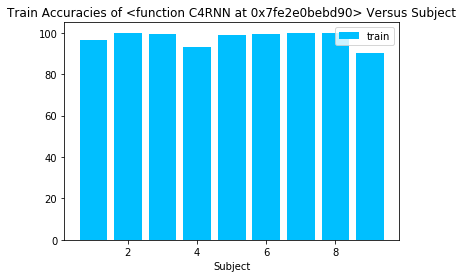

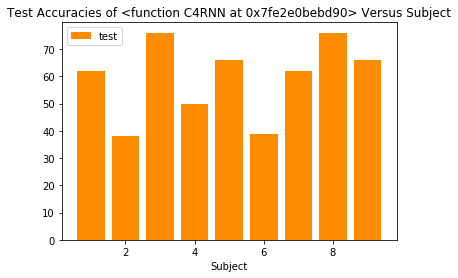

Train Accuracy:
[96.62446975708008, 100.0, 99.57627058029175, 93.16239356994629, 98.72340559959412, 99.57627058029175, 100.0, 100.0, 90.04328846931458]
Test Accuracy
[62.00000047683716, 37.99999952316284, 75.99999904632568, 50.0, 65.95744490623474, 38.77550959587097, 62.00000047683716, 75.99999904632568, 65.95744490623474]


In [ ]:
trainVersusSubject(C4RNN,X_train=X_train_valid_smooth,X_test=X_test_smooth)